<a href="https://colab.research.google.com/github/sasi-hacker/selenium/blob/master/Sent_June_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
!gdown --id 1-PJqLhDmMANhzJIvvpBIi9cXDDHDjvbR

Downloading...
From: https://drive.google.com/uc?id=1-PJqLhDmMANhzJIvvpBIi9cXDDHDjvbR
To: /content/data.zip
84.9MB [00:00, 111MB/s]


In [ ]:
!rm -rf training.1600000.processed.noemoticon.csv
!unzip data.zip

Archive:  data.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import pandas as pd
import csv
df = pd.read_csv("training.1600000.processed.noemoticon.csv",quoting=csv.QUOTE_ALL,encoding='latin-1',header=None)
df.columns = ['Target','ID','Date','Query','User_ID','Text']
df.head()

,Target,ID,Date,Query,User_ID,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


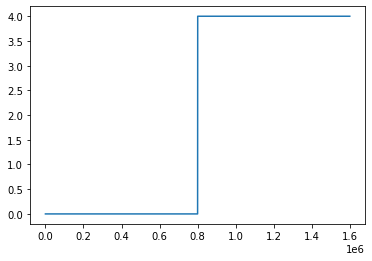

In [ ]:
df['Target'].plot()

In [ ]:
df['Target'].describe()

count    1.600000e+06
mean     2.000000e+00
std      2.000001e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.000000e+00
Name: Target, dtype: float64

**Pre-process Data**

In [ ]:
df['Target'].fillna(value=df['Target'].mode(),inplace=True)

In [ ]:
_ = df.pop('ID')
_ = df.pop('Date')
_ = df.pop('Query')
_ = df.pop('User_ID')

In [ ]:
df.dropna(subset=['Text'],inplace=True)

In [ ]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

def remove_usernames(sentence):
    return re.sub(r'@[A-Z0-9a-z_:]+','',sentence)

def remove_retweet_tags(sentence):
    return re.sub(r'^[RT]+','',sentence)

def remove_urls(sentence):
    return re.sub(r'(http|https|ftp)?://[A-Za-z0-9./]+','',sentence)

def clean_tweet(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_retweet_tags(tweet)
    tweet = remove_urls(tweet)
    return tweet.strip()

def remove_stopwords(tweet):
    return " ".join([word for word in tweet.split(" ") if word.lower() not in nlp.Defaults.stop_words])

def preproccess_pipeline(tweet):
    tweet = clean_tweet(tweet)
    tweet = remove_stopwords(tweet)
    return tweet

df['Text'] = df['Text'].apply(preproccess_pipeline)
df.head()

,Target,Text
0,0,"- Awww, that's bummer. shoulda got David Carr..."
1,0,upset can't update Facebook texting it... cry ...
2,0,dived times ball. Managed save 50% rest bounds
3,0,body feels itchy like fire
4,0,"no, it's behaving all. i'm mad. here? can't th..."


In [ ]:
df.to_csv('clean_tweet.csv')

In [ ]:
sentences = df['Text'].tolist()
labels = df['Target'].tolist()
del df

In [ ]:
import numpy as np
training_size = int(len(sentences) * 0.8)

train_x = sentences[0: training_size]
test_x = sentences[: training_size]
train_y = labels[0: training_size]
test_y = labels[: training_size]

# Put labels into list to use later:

train_x = np.array(train_x)
train_y = np.array(train_y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 512

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)
train_x = tokenizer.texts_to_sequences(train_x)
train_x = pad_sequences(train_x, maxlen=512, padding='post', truncating='post')
# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 5)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
model.fit(train_x, train_y,
  batch_size=32,
  epochs=5,
  verbose=1,
  validation_split=0.2,
  shuffle=True)

Epoch 1/5
32000/32000 [==============================] - 138s 4ms/step - loss: 0.5375 - accuracy: 0.7795 - val_loss: 1.4384 - val_accuracy: 0.0000e+00
Epoch 2/5
32000/32000 [==============================] - 121s 4ms/step - loss: 0.5284 - accuracy: 0.7814 - val_loss: 1.6758 - val_accuracy: 0.0000e+00
Epoch 3/5
32000/32000 [==============================] - 117s 4ms/step - loss: 0.5269 - accuracy: 0.7819 - val_loss: 1.6761 - val_accuracy: 0.0000e+00
Epoch 4/5
32000/32000 [==============================] - 120s 4ms/step - loss: 0.5286 - accuracy: 0.7807 - val_loss: 1.5994 - val_accuracy: 0.0000e+00
Epoch 5/5
32000/32000 [==============================] - 118s 4ms/step - loss: 0.5281 - accuracy: 0.7812 - val_loss: 1.5139 - val_accuracy: 0.0000e+00


In [ ]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json,f)

In [ ]:
model.save("twitter-sentiment-model")

INFO:tensorflow:Assets written to: twitter-sentiment-model/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r 'twitter-sentiment-model' '/content/drive/MyDrive/twitter-sentiment-model'

In [ ]:
!cp tokenizer.json /content/drive/MyDrive/tokenizer.json